In [1]:
##%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

In [2]:
# We generate the extra metadata needed for multi-faceted grids
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/home/ollie/mlosch/MITgcm/nils/llc90/input/','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [21]:
deltat=3600.
ny, nx = 1170, 90

bdir='/work/ollie/mlosch/idemix_test/llc90'
rdir0,deltat='/work/ollie/mlosch/idemix_test/llc90/run09', 3600.
#rdir1='/work/ollie/mlosch/idemix_test/llc90/run03_idemix'
prefix=['diagSeaice']

In [22]:
ds = open_mdsdataset(os.path.join(rdir0),prefix=prefix,
                     delta_t=deltat,ref_date="1772-1-1 0:0:0",geometry='llc')
coords = ds.coords.to_dataset().reset_coords()
#ds = ds.reset_coords(drop=True)
# fix coordinates
ds.coords['XC'] = grid.XC
ds.coords['YC'] = grid.YC
ds

<xarray.Dataset>
Dimensions:               (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, face: 13, l1_b: 89, l1_c: 88, l1_i: 87, time: 562)
Coordinates: (12/51)
  * i                     (i) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i_g                   (i_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * j                     (j) int64 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * j_g                   (j_g) int64 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * k                     (k) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
  * k_u                   (k_u) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
    ...                    ...
    dyU                   (face, j_g, i_g) >f4 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    layer_1RHO_bounds     (l1_b) >f4 dask.array<chunksize=(89,), meta=np.ndarray>
    layer_1RHO_center     (l1_c) float32 dask.array<chunksize=(88,), meta=np.ndarray>
    layer_1RHO_interface  (l1_i) >f4 dask.array<chunksize=(87,), meta=np.ndarray>
    iter                  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2019-01-01 ... 2020-07-15
Data variables:
    SIarea                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIheff                (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIhsnow               (time, face, j, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIuice                (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
    SIvice                (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [23]:
ds.time

<xarray.DataArray 'time' (time: 562)>
array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', ..., '2020-07-13T00:00:00.000000000',
       '2020-07-14T00:00:00.000000000', '2020-07-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-07-15
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

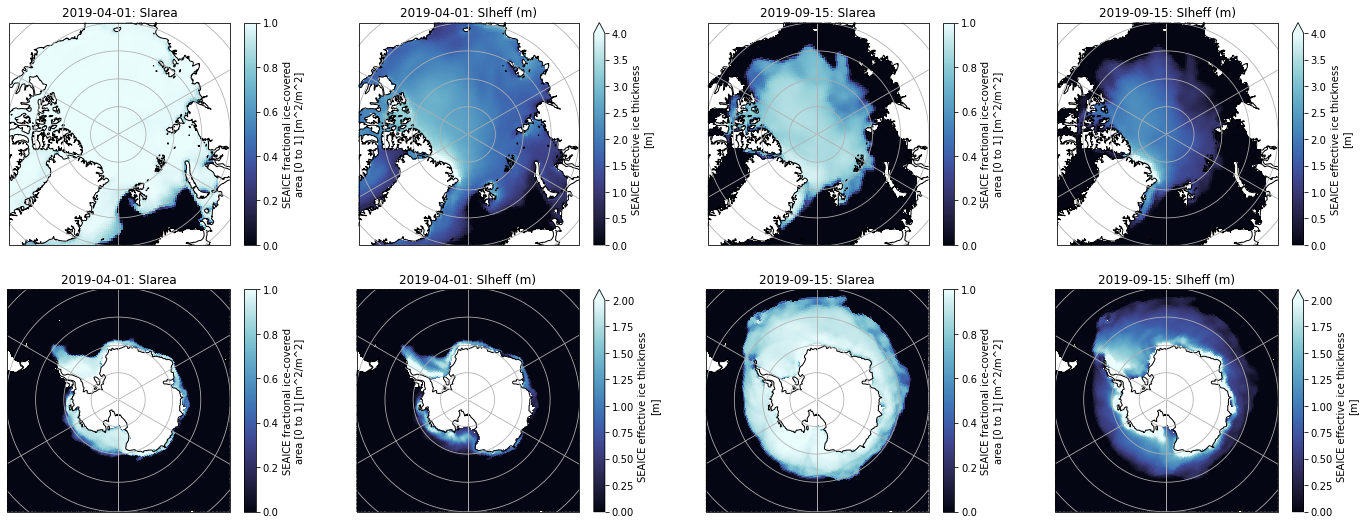

In [24]:
plt.close('all')
mytindex=ds.time.shape[0]-1
# mytindex=31+28+31 # April 01
# mytindex=31+28+31+30+31+30+31+31+30 # October 01
# mytime=ds.time.isel(time=mytindex)
# spring=ds.time.sel(time='2018-04-01')
# fall=ds.time.sel(time='2018-09-15')
spring=ds.time.sel(time='2019-04-01')
fall=ds.time.sel(time='2019-09-15')

def plot2dmap(ax,ds,fld,levs,tstr='dummy',cmap=None):
    
    ax.set_global()
    # for iface in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # for iface in [0,1,2,3,4,5,10,11,12]:
    for iface in range(13):
        if iface==12: 
            clrbr=True
            # cbarargs={"orientation": "horizontal"}
            cbarargs={"extend": "both", "orientation": "vertical"}
            if levs.vmin==0. and levs.vmax==1.:
                cbarargs["extend"] = "neither"
            elif levs.vmin==0.: 
                cbarargs["extend"] = "max"
        else:
            clrbr=False
            cbarargs=None

        fld.isel(face=iface).plot.pcolormesh(ax=ax, transform=cart.crs.PlateCarree(), x="XC", y="YC", norm=levs,
                                             add_colorbar=clrbr, cmap=cmap, cbar_kwargs=cbarargs)
    
    ax.set_title('%s'%(tstr))
    ax.coastlines()
    # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()

#proj=cart.crs.Orthographic(-80, 35)#central_longitude=180.0-19) #central_longitude=7.0)
nproj=cart.crs.NorthPolarStereo()
sproj=cart.crs.SouthPolarStereo()
nextent=[-180, 180, 70, 90]
sextent=[-180, 180, -90, -50]


mask2d=ds.hFacC.isel(k=0)

nrows=2
ncols=4
fig = plt.figure(figsize=(24,9))
# nrows=4
# ncols=2
# fig = plt.figure(figsize=(12,18))

ax=[]
# northern hemisphere
ax0 = fig.add_subplot(nrows,ncols,1, projection=nproj)
plot2dmap(ax0,ds,ds.SIarea.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='%s: SIarea'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,2, projection=nproj)
plot2dmap(ax0,ds,ds.SIheff.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
          tstr='%s: SIheff (m)'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,3, projection=nproj)
plot2dmap(ax0,ds,ds.SIarea.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='%s: SIarea'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,4, projection=nproj)
plot2dmap(ax0,ds,ds.SIheff.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
          tstr='%s: SIheff (m)'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(nextent,cart.crs.PlateCarree())
ax.append(ax0)

# southern hemisphere
ax0 = fig.add_subplot(nrows,ncols,5, projection=sproj)
plot2dmap(ax0,ds,ds.SIarea.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='%s: SIarea'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,6, projection=sproj)
plot2dmap(ax0,ds,ds.SIheff.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=2.),
          tstr='%s: SIheff (m)'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,7, projection=sproj)
plot2dmap(ax0,ds,ds.SIarea.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
          tstr='%s: SIarea'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

ax0 = fig.add_subplot(nrows,ncols,8, projection=sproj)
plot2dmap(ax0,ds,ds.SIheff.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=2.),
          tstr='%s: SIheff (m)'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice)
ax0.set_extent(sextent,cart.crs.PlateCarree())
ax.append(ax0)

#fig.suptitle('Simulation day %s'%(ds.time.sel(time=mytime).data.astype('datetime64[D]')))

In [6]:
# for a in ax:
#     a.set_extent([-180, 180, 70, 90],cart.crs.PlateCarree())

In [7]:
# sproj=cart.crs.SouthPolarStereo()
# sextent=[-180, 180, -90, -50]

# fig = plt.figure(figsize=(12,9))
# ax=[]

# ax0 = fig.add_subplot(2,2,1, projection=sproj)
# plot2dmap(ax0,ds,ds.SIarea.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
#           tstr='%s: SIarea'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
# ax0.set_extent(sextent,cart.crs.PlateCarree())
# ax.append(ax0)

# ax0 = fig.add_subplot(2,2,2, projection=sproj)
# plot2dmap(ax0,ds,ds.SIarea.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=1.),
#           tstr='%s: SIarea'%(ds.time.sel(time=spring).data.astype('datetime64[D]')),cmap=cmo.ice)
# ax0.set_extent(sextent,cart.crs.PlateCarree())
# ax.append(ax0)

# ax0 = fig.add_subplot(2,2,3, projection=sproj)
# plot2dmap(ax0,ds,ds.SIheff.sel(time=spring).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
#           tstr='%s: SIheff (m)'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice_r)
# ax0.set_extent(sextent,cart.crs.PlateCarree())
# ax.append(ax0)

# ax0 = fig.add_subplot(2,2,4, projection=sproj)
# plot2dmap(ax0,ds,ds.SIheff.sel(time=fall).where(mask2d!=0.),colors.Normalize(vmin=0.,vmax=4.),
#           tstr='%s: SIheff (m)'%(ds.time.sel(time=fall).data.astype('datetime64[D]')),cmap=cmo.ice_r)
# ax0.set_extent(sextent,cart.crs.PlateCarree())
# ax.append(ax0)